In [1]:
# import h2o lib and allow it to use max. threads
library(h2o)
h2o.init(nthreads = -1)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T//RtmpANa9UV/h2o_phall_started_from_r.out
    /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T//RtmpANa9UV/h2o_phall_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 962 milliseconds 
    H2O cluster version:        3.12.0.1 
    H2O cluster version age:    29 days  
    H2O cluster name:           H2O_started_from_R_phall_hdi449 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.2 (2016-10-31) 

In [2]:
# location of clean data file
path <- "https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv"

In [3]:
# import file
frame <- h2o.importFile(path)

# strings automatically parsed as enums (categorical)
# numbers automatically parsed as numeric
# bad_loan is numeric, but categorical
frame$bad_loan <- as.factor(frame$bad_loan)

  |======================================================================| 100%


In [4]:
# find missing numeric and impute
for (name in names(frame)) {
  if (any(is.na(frame[name]))) {
      h2o.impute(frame, name, "median")
  }
}

In [5]:
h2o.describe(frame) # summarize table, check for missing

Label,Type,Missing,Zeros,PosInf,NegInf,Min,Max,Mean,Sigma,Cardinality
loan_amnt,int,0,0,0,0,500.00,35000.00,1.307417e+04,7.993556e+03,NA
term,enum,0,129950,0,0,0.00,1.00,2.075591e-01,4.055605e-01,2
int_rate,real,0,0,0,0,5.42,26.06,1.371590e+01,4.391940e+00,NA
emp_length,int,0,14248,0,0,0.00,10.00,5.695525e+00,3.546671e+00,NA
home_ownership,enum,0,1,0,0,0.00,5.00,NA,NA,6
annual_inc,real,0,0,0,0,1896.00,7141778.00,7.191540e+04,5.907022e+04,NA
purpose,enum,0,2842,0,0,0.00,13.00,NA,NA,14
addr_state,enum,0,413,0,0,0.00,49.00,NA,NA,50
dti,real,0,270,0,0,0.00,39.99,1.588153e+01,7.587668e+00,NA
delinq_2yrs,int,0,139488,0,0,0.00,29.00,2.273168e-01,6.941131e-01,NA


In [6]:
# assign target and inputs
y <- 'bad_loan'
X <- names(frame)[names(frame) != y]
print(y)
print(X)

[1] "bad_loan"
 [1] "loan_amnt"             "term"                  "int_rate"             
 [4] "emp_length"            "home_ownership"        "annual_inc"           
 [7] "purpose"               "addr_state"            "dti"                  
[10] "delinq_2yrs"           "revol_util"            "total_acc"            
[13] "longest_credit_length" "verification_status"  


In [7]:
# split into training and valid
split <- h2o.splitFrame(frame, ratios = 0.7)
train <- split[[1]]
valid <- split[[2]]

In [8]:
# neural network

# train
loan_nn <- h2o.deeplearning(
    x = X,
    y = y,
    training_frame = train,
    validation_frame = valid,
    epochs = 50,                     # read over the data 50 times, but in mini-batches
    hidden = c(100),                 # 100 hidden units in 1 hidden layer
    input_dropout_ratio = 0.2,       # randomly drop 20% of inputs for each iteration, helps w/ generalization
    hidden_dropout_ratios = c(0.05), # randomly set 5% of hidden weights to 0 each iteration, helps w/ generalization
    activation = "TanhWithDropout",  # bounded activation function that allows for dropout, tanh, more stable
    l1 = 0.001,                      # L1 penalty can help generalization   
    l2 = 0.01,                       # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate = TRUE,            # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds = 5,             # stop after validation error does not decrease for 5 iterations
    score_each_iteration = TRUE,     # score validation error on every iteration, use with caution
    model_id = "loan_nn")            # for easy lookup in flow

# print model information
loan_nn

# view detailed results at http://ip:port/flow/index.html

  |======================================================================| 100%


Model Details:

H2OBinomialModel: deeplearning
Model ID:  loan_nn 
Status of Neuron Layers: predicting bad_loan, 2-class classification, bernoulli distribution, CrossEntropy loss, 9,102 weights/biases, 113.9 KB, 1,499,454 training samples, mini-batch size 1
  layer units        type dropout       l1       l2 mean_rate rate_rms momentum
1     1    88       Input 20.00 %                                              
2     2   100 TanhDropout  5.00 % 0.001000 0.010000  0.435807 0.213413 0.000000
3     3     2     Softmax         0.001000 0.010000  0.371618 0.119549 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.000043   0.043418 -0.001562 0.015021
3    0.000007   0.054791 -0.002201 0.526567


H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 9942 samples **

MSE:  0.1406922
RMSE:  0.3750896
LogLoss:  0.4450111
Mean Per-Class Error:  0.3520499
AUC:  0.6937272
Gini: 

In [9]:
# NN with random hyperparameter search
# train many different NN models with random hyperparameters

# define random grid search parameters
hidden_opts = c(c(170, 320), c(80, 190), c(320, 160, 80), c(100), c(50, 50, 50, 50))
l1_opts = seq(0.001, 0.01, 0.001)
l2_opts = seq(0.001, 0.01, 0.001)
input_dropout_ratio_opts = seq(0.01, 0.5, 0.01)


hyper_params = list(hidden = hidden_opts,
                    l1 = l1_opts,
                    l2 = l2_opts,
                    input_dropout_ratio = input_dropout_ratio_opts)

# search a random subset of these hyper-parmameters
# max runtime and max models are enforced
# and the search will stop after not improving much over the best 5 random models
search_criteria = list(strategy = "RandomDiscrete", 
                       max_runtime_secs = 600, 
                       max_models = 20, 
                       stopping_metric = "AUC", 
                       stopping_tolerance = 0.0001, 
                       stopping_rounds = 5, 
                       seed = 123456)

# execute training w/ grid search
loan_nn2 <- h2o.grid("deeplearning", 
                     grid_id = "nn_grid",
                     x = X, 
                     y = y, 
                     training_frame = train,
                     validation_frame = valid,
                     
                     # per model stopping criteria 
                     stopping_rounds = 2,
                     stopping_tolerance = 1e-3,
                     stopping_metric = "AUC",
                     
                     # how often to score (affects early stopping, and training speed)
                     score_interval = 5, 
                     
                     # seed to control sampling
                     seed = 12345,
                     
                     # grid serach options
                     hyper_params = hyper_params,
                     search_criteria = search_criteria)

# view detailed results at http://ip:port/flow/index.html

  |======================================================================| 100%


In [10]:
# show grid results
sorted_grid <- h2o.getGrid(grid_id = "nn_grid")
print(sorted_grid)

H2O Grid Details

Grid ID: nn_grid 
Used hyper parameters: 
  -  hidden 
  -  input_dropout_ratio 
  -  l1 
  -  l2 
Number of models: 20 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
   hidden input_dropout_ratio    l1    l2        model_ids             logloss
1   [190]                0.24 0.007 0.004  nn_grid_model_7 0.43876941299007494
2    [80]                0.38 0.002 0.006 nn_grid_model_18  0.4388555388005006
3    [50]                0.08 0.002 0.006 nn_grid_model_11  0.4394941394072266
4    [80]                0.26 0.002 0.006  nn_grid_model_2   0.439635681974603
5    [80]                0.29 0.008 0.001 nn_grid_model_14  0.4399358703648209
6    [50]                0.42 0.003 0.005 nn_grid_model_10 0.43995725532347085
7   [320]                0.03 0.004 0.001 nn_grid_model_15  0.4399809747889494
8   [190]                0.26 0.001 0.005  nn_grid_model_0  0.4406673163150426
9   [100]                0.05 0.009 0.004  nn_grid_model_4 

In [11]:
# select best model
best_model <- h2o.getModel(sorted_grid@model_ids[[1]])
summary(best_model)

Model Details:

H2OBinomialModel: deeplearning
Model Key:  nn_grid_model_7 
Status of Neuron Layers: predicting bad_loan, 2-class classification, bernoulli distribution, CrossEntropy loss, 17,292 weights/biases, 211.0 KB, 1,200,073 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    88     Input 24.00 %                                              
2     2   190 Rectifier  0.00 % 0.007000 0.004000  0.135315 0.257733 0.000000
3     3     2   Softmax         0.007000 0.004000  0.100201 0.023495 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.022597   0.052214  0.002675 0.049715
3    0.000038   0.051122 -0.000175 0.161525

H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 9922 samples **

MSE:  0.1420352
RMSE:  0.3768756
LogLoss:  0.4493461
Mean Per-Class Error:  0.3565197
AUC:  0.6945474
Gini:

  |======================================================================| 100%


int_rate,mean_response,stddev_response
5.420000,0.07247191,0.02992528
6.506316,0.08051394,0.03285655
7.592632,0.08935017,0.03599445
8.678947,0.09903735,0.03933591
9.765263,0.10963147,0.04287249
10.851579,0.12118706,0.04659355
11.937895,0.13375293,0.05046694
13.024211,0.14737321,0.05445964
14.110526,0.16208283,0.05852398
15.196842,0.17790922,0.06261698


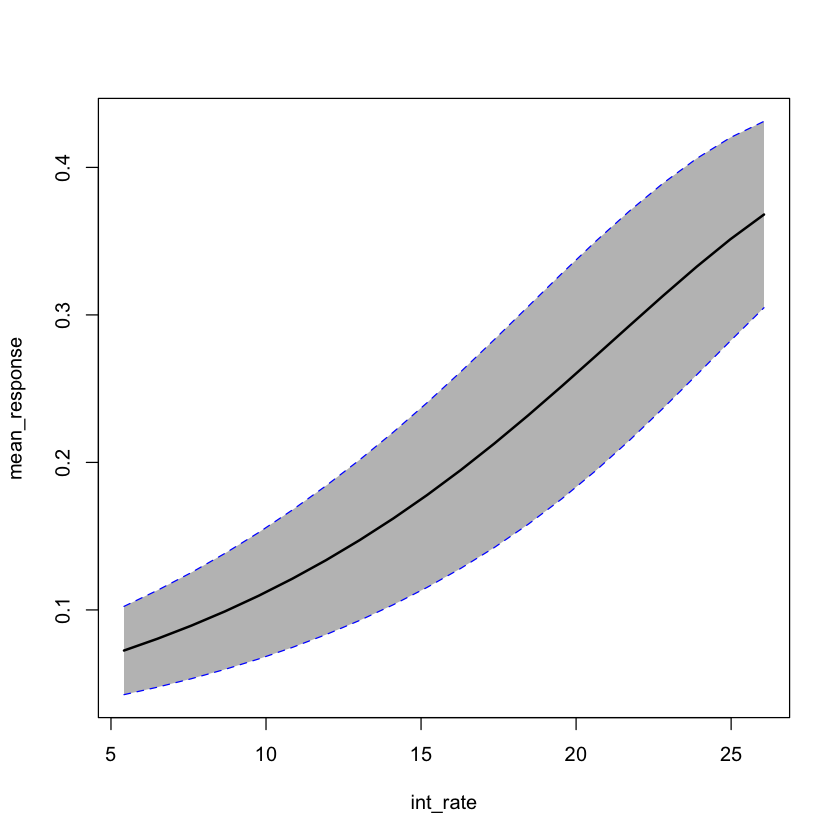

In [12]:
# use partial dependence plots to get insight into important relationships
h2o.partialPlot(best_model, valid, "int_rate")

In [13]:
h2o.shutdown(prompt = FALSE)

[1] TRUE